### Preliminaries

In [1]:
# Autoreload all modules when changes are saved. 
%reload_ext autoreload
%autoreload 2  

# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import olf_pred

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from olf_pred.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from olf_pred.gerkin import dream,fit2

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
num_subjects = 49
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [6]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [7]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [8]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


### Create Molecular Matrix

In [9]:
X_training,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"training")
X_training.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 676 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (676x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (676x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (676x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (676x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors


(676, 3033)

In [10]:
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_other.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [11]:
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [12]:
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_other.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [13]:
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_int.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [14]:
X_all,good1,good2,means,stds,imputer = dream.make_X(molecular_data,['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)
X_all.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 814 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (814x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (814x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (814x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (814x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (814x3033) molecules by non-NaN good molecular descriptors


(814, 3033)

In [15]:
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one

In [16]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [17]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [18]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Data preparation

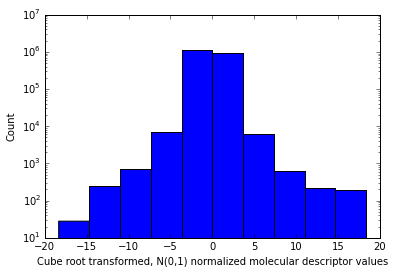

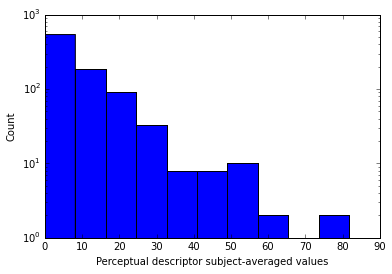

In [19]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(Y_training_imp['mean_std'][:21].ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Perceptual descriptor subject-averaged values')

## Fitting and Generating Submission Files

In [20]:
write = True # Set to True to actually generate the prediction files.  
n_estimators = 1 # Set this to a high number (e.g. 1000) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':{'mean':None,'sigma':None},
                'ple':{'mean':100,'sigma':None},
                'dec':{'mean':500,'sigma':500}}
min_samples_leaf = {'int':{'mean':1,'sigma':4},
                'ple':{'mean':1,'sigma':1},
                'dec':{'mean':1,'sigma':1}}
max_depth = {'int':{'mean':None,'sigma':2},
                'ple':{'mean':10,'sigma':10},
                'dec':{'mean':10,'sigma':10}}
et = {'int':{'mean':True,'sigma':True},
                'ple':{'mean':False,'sigma':False},
                'dec':{'mean':False,'sigma':False}}
#et['int'] = {'mean':False,'sigma':False} # Uncomment to get a correct score estimate, or leave commented to get best fit.  
use_mask = {'int':{'mean':False,'sigma':True},
                'ple':{'mean':False,'sigma':True},
                'dec':{'mean':False,'sigma':True}}

In [21]:
# Fit training data.  Ignoring warning that arises if too few trees are used.  
rfcs_leaderboard,score,rs = fit2.rfc_final(X_training,Y_training_imp['mean_std'],Y_training_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

For subchallenge 2:
	Score = 2.79
	int_mean = 1.000
	int_sigma = 0.093
	ple_mean = -0.018
	ple_sigma = -0.022
	dec_mean = 0.143
	dec_sigma = 0.070


/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/ensemble/forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [22]:
loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,'testset',2,write=False)

{'mean_std': array([[  5.22448980e+01,   6.03877551e+01,   8.97959184e-01, ...,
           1.17157894e+01,   8.29309475e+00,   3.15377888e+01],
        [  5.18775510e+01,   5.27551020e+01,   2.04081633e-02, ...,
           1.66180092e+01,   1.36121961e+01,   3.28608656e+01],
        [  7.63061224e+01,   4.77755102e+01,   1.91320072e+00, ...,
           1.43150894e+01,   1.67177457e+01,   1.42573630e+01],
        ..., 
        [  1.83877551e+01,   4.74030612e+01,   2.11224490e+00, ...,
           7.80151823e+00,   2.19731437e+01,   1.75363600e+01],
        [  5.58367347e+01,   3.37959184e+01,   2.06122449e+00, ...,
           1.02576279e+01,   1.97407284e+01,   2.84227625e+01],
        [  2.33061224e+01,   4.50578231e+01,   1.36209913e+00, ...,
           1.04250205e+01,   1.38828536e+01,   1.78783390e+01]]),
 'subject': {}}

In [23]:
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

For subchallenge 2:
	Score = 2.83
	int_mean = 1.000
	int_sigma = 0.126
	ple_mean = 0.009
	ple_sigma = -0.010
	dec_mean = 0.133
	dec_sigma = 0.072


In [24]:
loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=False)

{'mean_std': array([[ 33.26530612,  44.62244898,   2.12244898, ...,   9.93389033,
          10.11045229,  21.72142009],
        [ 12.95918367,  48.15306122,   0.91836735, ...,   7.59583474,
          18.41829388,  22.26213039],
        [ 21.16326531,  44.62244898,   8.12244898, ...,   4.7887756 ,
           8.37787436,  24.78012562],
        ..., 
        [ 39.53061224,  59.50204082,   3.82780612, ...,  12.27196668,
          22.87507041,  19.62084018],
        [ 18.3877551 ,  57.82653061,   1.42212675, ...,   8.39165909,
          14.20939341,  23.09079336],
        [ 29.08163265,  49.21836735,   3.95918367, ...,  11.30602357,
          31.18954828,  22.55003619]]), 'subject': {}}